#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

In [64]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import itertools

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

### Set the random seed for reproducible results
torch.manual_seed(0)

## Dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


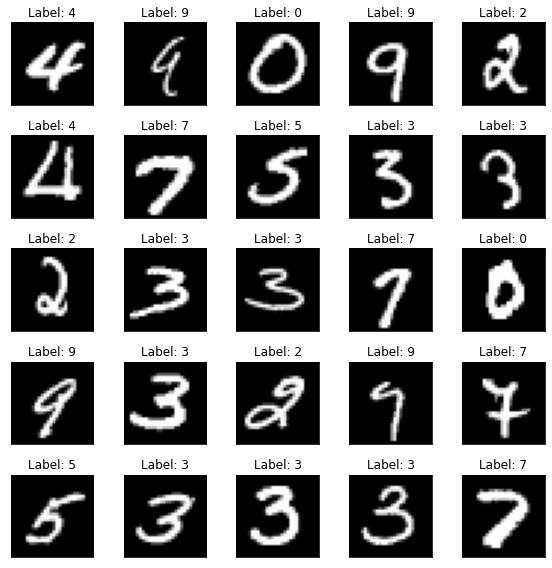

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


## Autoencoder

### Encoder

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout=0):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(288, 64),
            nn.ReLU(),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x) 
        # Apply linear layers
        x = self.encoder_lin(x) 
        return x

# simple check of the shape 
sample = next(iter(train_dataloader)) # returns the first sample 
sample = sample[0] # actual image
print(sample.shape)

encoded_space_dim = 2 
enc = Encoder(encoded_space_dim) 
out = enc(sample) 
print(out.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256, 2])


### Decoder

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, dropout=0):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Dropout(p=dropout)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## Training and testing functions

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch) 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data

In [11]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data) 
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [12]:
def fit(num_epochs, encoder, decoder, device, train_dataloader, loss_fn, optim, test_dataloader, test_dataset, patience, plot_progress=False):
    train_loss_log = []
    val_loss_log = [] 
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_log.append(train_loss)
        ### Validation (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        val_loss_log.append(val_loss)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, decoder)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        ### Plot progress
        if plot_progress:
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(12,6))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)
            # Save figures
            os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
            fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
            plt.show()
            plt.close()
        # Save network parameters
        #torch.save(encoder.state_dict(), 'encoder_params.pth')
        #torch.save(decoder.state_dict(), 'decoder_params.pth')
        #torch.save(optim.state_dict(), 'optim_params.pth')
    return train_loss_log, val_loss_log 

## Hyperparameter search

In [40]:
# Hyperparameters
encoded_space_dim = [4, 8, 16]
num_epochs = [50, 100, 150]
lr = [1e-2, 1e-3, 1e-4]
decay = [1e-3, 1e-4, 1e-5]
dropout = [0, 0.1, 0.2]
patience = [5]

hyperparams = [encoded_space_dim, num_epochs, lr, decay, dropout, patience]
configs = list(itertools.product(*hyperparams))
print('Possible combinations:', len(configs))

Possible combinations: 243


In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

best_loss = None
best_hp = None
for iteration, hp in enumerate(configs):
    print('--------------------------------------------------------')
    print('Iteration:', iteration)
    print('Hyperparameters:', hp)
    # Loss function
    loss_fn = nn.MSELoss()
    # Iteration's hyperparameters
    encoded_space_dim, num_epochs, lr, decay, dropout, patience = hp
    # Networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim, dropout=dropout) 
    decoder = Decoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
    # Optimizers
    autoenc_params = [{'params': encoder.parameters()}, 
                      {'params': decoder.parameters()}]
    optim = torch.optim.Adam(autoenc_params, lr=lr, weight_decay=decay) 
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    # Train
    train_loss_log, val_loss_log = fit(num_epochs=num_epochs,
                                       encoder=encoder,
                                       decoder=decoder,
                                       device=device,
                                       train_dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optim=optim,
                                       test_dataloader=test_dataloader,
                                       test_dataset=test_dataset,
                                       patience=patience,
                                       plot_progress=False)
    train_loss = train_loss_log[-1]
    val_loss = val_loss_log[-1]
    print('Train loss:', train_loss, '\nValidation loss:', val_loss)
    if not best_loss or val_loss < best_loss:
        best_hp = hp 
        best_loss = val_loss

print('###################################################################')
print('BEST PARAMETERS:', best_hp)

## Train with best parameters

In [15]:
# If you have trained the model, comment this cell
best_hp = (8, 5, 1e-3, 1e-5, 0, 5)

In [38]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Loss function
loss_fn = nn.MSELoss()
# Iteration's hyperparameters
encoded_space_dim, num_epochs, lr, decay, dropout, patience = best_hp 
# Networks
encoder = Encoder(encoded_space_dim=encoded_space_dim, dropout=dropout) 
decoder = Decoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
# Optimizers
autoenc_params = [{'params': encoder.parameters()}, 
                  {'params': decoder.parameters()}]
optim = torch.optim.Adam(autoenc_params, lr=lr, weight_decay=decay) 
# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
# Train
train_loss_log, val_loss_log = fit(num_epochs=num_epochs,
                                   encoder=encoder,
                                   decoder=decoder,
                                   device=device,
                                   train_dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optim=optim,
                                   test_dataloader=test_dataloader,
                                   test_dataset=test_dataset,
                                   patience=patience,
                                   plot_progress=False)

print('Train loss:', train_loss_log[-1].detach().cpu().numpy())
print('Validation loss:', val_loss_log[-1].detach().cpu().numpy())

# Save network parameters
torch.save(encoder.state_dict(), 'encoder_params.pth')
torch.save(decoder.state_dict(), 'decoder_params.pth')
torch.save(optim.state_dict(), 'optim_params.pth')

Selected device: cuda
EPOCH 1/5


	 VALIDATION - EPOCH 1/5 - loss: 0.068030


EPOCH 2/5


	 VALIDATION - EPOCH 2/5 - loss: 0.067653


EPOCH 3/5


	 VALIDATION - EPOCH 3/5 - loss: 0.067162


EPOCH 4/5


	 VALIDATION - EPOCH 4/5 - loss: 0.062734


EPOCH 5/5


	 VALIDATION - EPOCH 5/5 - loss: 0.059535


Train loss: 0.057857968
Validation loss: 0.05953488


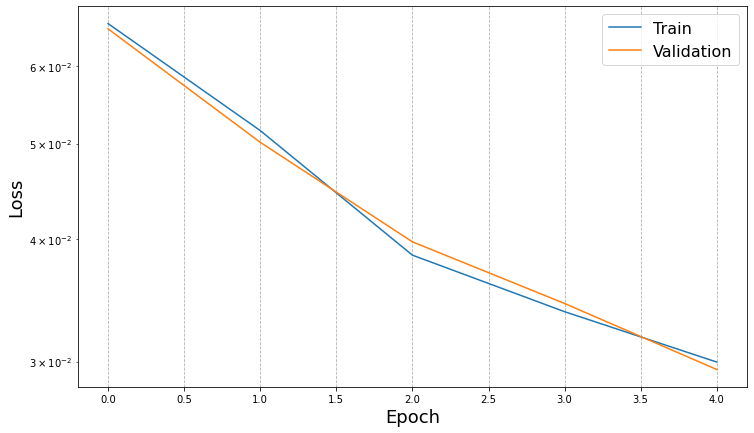

In [22]:
plt.figure(figsize=(12,7))
plt.plot(train_loss_log, label='Train')
plt.plot(val_loss_log, label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(ls='--')
plt.legend(fontsize=16)
plt.savefig('AE_loss.pdf', bbox_inches='tight')
plt.show()

## Test the model

In [23]:
test_loss = test_epoch(encoder=encoder,
                       decoder=decoder,
                       device=device,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn)
print('Test loss', test_loss)

Test loss tensor(0.0295)


## Network analysis

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

In [25]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [26]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:06<00:00, 1503.91it/s]


In [27]:
# Convert to a dataframe (for convenience)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,label
0,-13.986443,19.546995,-22.893147,-13.272181,2.484940,29.933857,9.712803,-10.506844,7
1,9.496259,30.739939,-31.100054,-1.389509,-7.926433,-3.463463,-46.829536,-23.320564,2
2,-36.316505,19.076239,-28.141933,13.941605,-18.189775,11.128605,-4.186471,-11.713206,1
3,14.024025,42.174152,-64.263969,9.680405,11.734209,29.329315,-28.981283,2.204142,0
4,-0.614600,47.435104,-25.879658,-5.092556,3.110859,27.000126,-9.494017,5.802735,4
...,...,...,...,...,...,...,...,...,...
9995,-1.178997,14.328546,-31.184725,-16.934563,21.344967,18.234314,-38.883469,-23.727684,2
9996,8.429633,20.878286,-51.465931,-15.212703,5.429594,14.765585,-32.813011,-26.707304,3
9997,-19.412651,39.213047,-52.645844,11.236515,2.301404,45.627934,-5.492447,-9.139601,4
9998,-12.683283,28.586653,-38.664398,22.137070,9.575563,28.661171,-14.236950,6.816519,5


### PCA

In [29]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples.iloc[:, 0:encoded_space_dim])

pca_transf_samples = pd.DataFrame(pca.transform(encoded_samples.iloc[:, 0:encoded_space_dim]), 
                                  columns=[f'Enc. Variable {i}' for i in range(n_components)])

fig = px.scatter(pca_transf_samples, 
                 x='Enc. Variable 0', 
                 y='Enc. Variable 1', 
                 color=encoded_samples.label.astype(str), 
                 opacity=0.7)
fig.show()

<Figure size 432x288 with 0 Axes>

### t-SNE

In [30]:
n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples.iloc[:, 0:encoded_space_dim])

tsne_tranf_samples = pd.DataFrame(tsne.fit_transform(encoded_samples.iloc[:, 0:encoded_space_dim]), 
                                  columns=[f'Enc. Variable {i}' for i in range(n_components)])

fig = px.scatter(tsne_tranf_samples, 
                 x='Enc. Variable 0', 
                 y='Enc. Variable 1', 
                 color=encoded_samples.label.astype(str), 
                 opacity=0.7)
fig.show()

<Figure size 432x288 with 0 Axes>

## Generate new samples

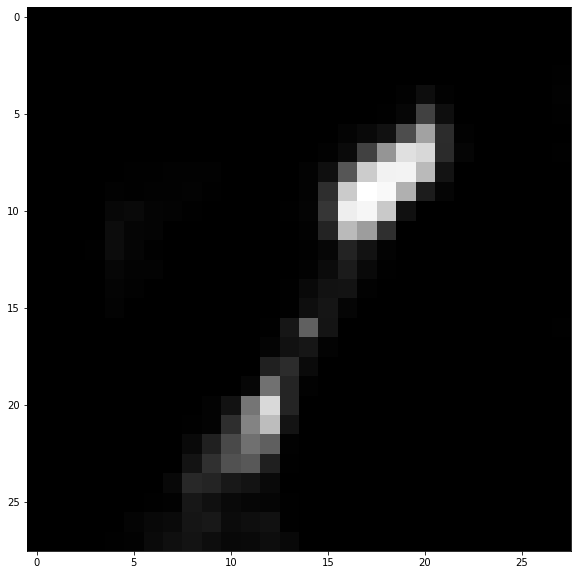

In [38]:
# Generate a custom sample
custom_encoded_sample = [-40.0, -10.0, 12.0, 5.0, 2.0, 9.0, 33.0, 1.0]
encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

# Decode sample
decoder.eval()
with torch.no_grad():
    generated_img  = decoder(encoded_value)

plt.figure(figsize=(12,10))
plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
plt.savefig('generated.pdf', bbox_inches='tight')
plt.show()

## Denoising autoencoder

In [24]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Add noise 
        mean = torch.randn(1).to(device)
        std = torch.randn(1).to(device) * 0.5 + 0.5
        noisy_image = image_batch + torch.randn(image_batch.size()).to(device) * std + mean
        # Encode data
        encoded_data = encoder(noisy_image)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch) 
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data

In [25]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Add noise
            mean = torch.randn(1).to(device)
            std = torch.randn(1).to(device) * 0.5 + 0.5
            noisy_image = image_batch + torch.randn(image_batch.size()).to(device) * std + mean 
            # Encode data
            encoded_data = encoder(noisy_image)
            # Decode data
            decoded_data = decoder(encoded_data) 
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [26]:
best_hp = (8, 5, 1e-3, 1e-5, 0, 5)

In [27]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Loss function
loss_fn = nn.MSELoss()
# Iteration's hyperparameters
encoded_space_dim, num_epochs, lr, decay, dropout, patience = best_hp 
# Networks
encoder = Encoder(encoded_space_dim=encoded_space_dim, dropout=dropout) 
decoder = Decoder(encoded_space_dim=encoded_space_dim, dropout=dropout)
# Optimizers
autoenc_params = [{'params': encoder.parameters()}, 
                  {'params': decoder.parameters()}]
optim = torch.optim.Adam(autoenc_params, lr=lr, weight_decay=decay) 
# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
# Train
train_loss_log, val_loss_log = fit(num_epochs=num_epochs,
                                   encoder=encoder,
                                   decoder=decoder,
                                   device=device,
                                   train_dataloader=train_dataloader,
                                   loss_fn=loss_fn,
                                   optim=optim,
                                   test_dataloader=test_dataloader,
                                   test_dataset=test_dataset,
                                   patience=patience,
                                   plot_progress=False)

print('Train loss:', train_loss_log[-1].detach().cpu().numpy())
print('Validation loss:', val_loss_log[-1].detach().cpu().numpy())

# Save network parameters
torch.save(encoder.state_dict(), 'denoise_encoder_params.pth')
torch.save(decoder.state_dict(), 'denoise_decoder_params.pth')
torch.save(optim.state_dict(), 'denoise_optim_params.pth')

Selected device: cuda
EPOCH 1/5


	 VALIDATION - EPOCH 1/5 - loss: 0.068407


EPOCH 2/5


	 VALIDATION - EPOCH 2/5 - loss: 0.067706


EPOCH 3/5


	 VALIDATION - EPOCH 3/5 - loss: 0.067544


EPOCH 4/5


	 VALIDATION - EPOCH 4/5 - loss: 0.065412


EPOCH 5/5


	 VALIDATION - EPOCH 5/5 - loss: 0.060673


Train loss: 0.06735492
Validation loss: 0.060673058


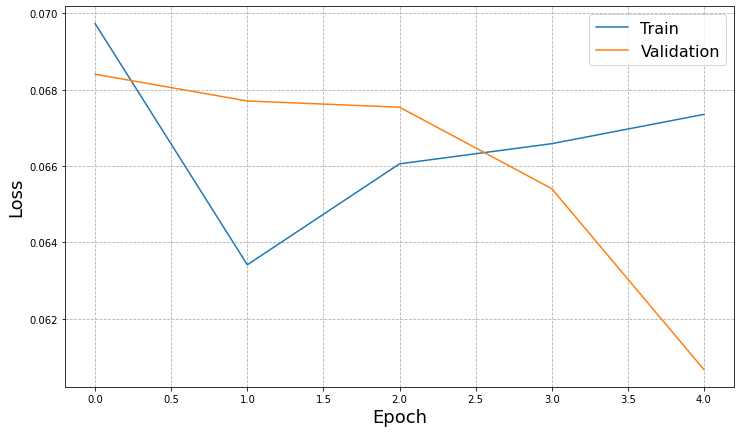

In [28]:
plt.figure(figsize=(12,7))
plt.plot(train_loss_log, label='Train')
plt.plot(val_loss_log, label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(ls='--')
plt.legend(fontsize=16)
plt.savefig('denoise_AE_loss.pdf', bbox_inches='tight')
plt.show()

In [29]:
test_loss = test_epoch(encoder=encoder,
                       decoder=decoder,
                       device=device,
                       dataloader=test_dataloader,
                       loss_fn=loss_fn)
print('Test loss', test_loss)

Test loss tensor(0.0611)


Text(0.5, 1.0, 'Decoded')

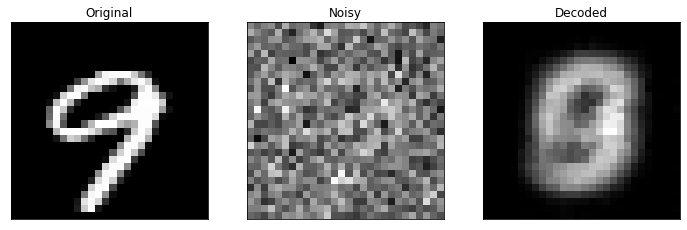

In [31]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
# Original
img, label = random.choice(test_dataset)
imgc = img[0]
ax[0].imshow(np.array(imgc), cmap='gist_gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original')
# Noisy
imgc += np.random.normal(0, 1, size=imgc.shape)
ax[1].imshow(np.array(imgc), cmap='gist_gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Noisy')
# Denoised
encoder.eval()
decoder.eval()
img = img.unsqueeze(0).to(device)
with torch.no_grad():
    enc_img = encoder(img)
    dec_img = decoder(enc_img)
ax[2].imshow(np.array(dec_img.detach().cpu()[0][0]), cmap='gist_gray')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Decoded')

## Fine-tune the AE using a supervised classification task

In [39]:
encoder

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Dropout2d(p=0, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
)

In [40]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in encoder.named_parameters():
    print(param_name)
    print('\tFreezing update')
    param.requires_grad = False

# Add classification layers
fine_encoder = nn.Sequential(encoder, 
                             nn.Linear(encoded_space_dim, 64),
                             nn.ReLU(True),
                             nn.Linear(64, 10),
                             nn.LogSoftmax())

encoder_cnn.0.weight
	Freezing update
encoder_cnn.0.bias
	Freezing update
encoder_cnn.2.weight
	Freezing update
encoder_cnn.2.bias
	Freezing update
encoder_cnn.4.weight
	Freezing update
encoder_cnn.4.bias
	Freezing update
encoder_lin.0.weight
	Freezing update
encoder_lin.0.bias
	Freezing update
encoder_lin.2.weight
	Freezing update
encoder_lin.2.bias
	Freezing update


In [41]:
fine_encoder

Sequential(
  (0): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU()
      (6): Dropout2d(p=0, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=8, bias=True)
    )
  )
  (1): Linear(in_features=8, out_features=64, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=64, out_features=10, bias=True)
  (4): LogSoftmax(dim=None)
)

In [42]:
# Check if correct
for param_name, param in fine_encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

0.encoder_cnn.0.weight 	- requires_grad=False
0.encoder_cnn.0.bias 	- requires_grad=False
0.encoder_cnn.2.weight 	- requires_grad=False
0.encoder_cnn.2.bias 	- requires_grad=False
0.encoder_cnn.4.weight 	- requires_grad=False
0.encoder_cnn.4.bias 	- requires_grad=False
0.encoder_lin.0.weight 	- requires_grad=False
0.encoder_lin.0.bias 	- requires_grad=False
0.encoder_lin.2.weight 	- requires_grad=False
0.encoder_lin.2.bias 	- requires_grad=False
1.weight 	- requires_grad=True
1.bias 	- requires_grad=True
3.weight 	- requires_grad=True
3.bias 	- requires_grad=True


In [43]:
# Define a loss function (CrossEntropyLoss)
loss_fn = torch.nn.CrossEntropyLoss() 

# Define an optimizer
optim = torch.optim.Adam(fine_encoder.parameters(), lr=0.001, weight_decay=1e-5) 

# Select the proper device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") ### INSERT YOUR CODE HERE

# Move all the network parameters to the selected device
fine_encoder.to(device) 

Sequential(
  (0): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU()
      (6): Dropout2d(p=0, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=8, bias=True)
    )
  )
  (1): Linear(in_features=8, out_features=64, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=64, out_features=10, bias=True)
  (4): LogSoftmax(dim=None)
)

In [50]:
### Training function
def train_epoch_class(net, device, dataloader, loss_fn, optimizer):
    # Set train mode
    net.train() 
    for image_batch, label_batch in dataloader:
        # Move tensors to the selected device
        image_batch = image_batch.to(device) 
        label_batch = label_batch.to(device)
        # Forward pass
        out = net(image_batch)
        # Evaluate loss
        loss = loss_fn(out, label_batch) 
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        # print('\t Training loss (single batch):', float(loss.data))

In [51]:
### Testing function
def test_epoch_class(net, device, dataloader, loss_fn):
    # Set evaluation mode
    net.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in tqdm(dataloader):
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            out = net(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss

In [52]:
### Training cycle
num_epochs = 20
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    print(f"EPOCH {epoch + 1}/{num_epochs}")
    ### Training
    train_epoch_class(net=fine_encoder, 
                device=device, 
                dataloader=train_dataloader, 
                loss_fn=loss_fn, 
                optimizer=optim)    
    ### Train loss (use the TESTING function! We want the train loss but using the network in eval mode and without random transformations)
    _, _, train_loss = test_epoch(net=fine_encoder, 
                                  device=device, 
                                  dataloader=train_dataloader, 
                                  loss_fn=loss_fn)
    # Print Train loss
    print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
    train_losses.append(train_loss)
    ### Validation
    _, _, val_loss = test_epoch_class(net=fine_encoder, 
                                device=device, 
                                dataloader=test_dataloader, 
                                loss_fn=loss_fn)
    # Print Validation loss
    print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
    val_losses.append(val_loss)
    ### Save model parameters
    torch.save(fine_encoder.state_dict(), 'finetuned_encoder.pth')

EPOCH 1/20


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
 18%|█▊        | 7/40 [00:00<00:00, 67.33it/s]



	 TRAIN - EPOCH 1/20 - train loss: 1.689688801765442




100%|██████████| 40/40 [00:00<00:00, 65.69it/s]




	 VALIDATION - EPOCH 1/20 - val loss: 1.6531654596328735


EPOCH 2/20


 18%|█▊        | 7/40 [00:00<00:00, 62.10it/s]



	 TRAIN - EPOCH 2/20 - train loss: 1.617846965789795




100%|██████████| 40/40 [00:00<00:00, 65.26it/s]




	 VALIDATION - EPOCH 2/20 - val loss: 1.583174467086792


EPOCH 3/20


 18%|█▊        | 7/40 [00:00<00:00, 67.02it/s]



	 TRAIN - EPOCH 3/20 - train loss: 1.581368327140808




100%|██████████| 40/40 [00:00<00:00, 65.57it/s]




	 VALIDATION - EPOCH 3/20 - val loss: 1.5426727533340454


EPOCH 4/20


 18%|█▊        | 7/40 [00:00<00:00, 67.50it/s]



	 TRAIN - EPOCH 4/20 - train loss: 1.5630488395690918




100%|██████████| 40/40 [00:00<00:00, 65.29it/s]




	 VALIDATION - EPOCH 4/20 - val loss: 1.5265405178070068


EPOCH 5/20


 18%|█▊        | 7/40 [00:00<00:00, 63.75it/s]



	 TRAIN - EPOCH 5/20 - train loss: 1.5576739311218262




100%|██████████| 40/40 [00:00<00:00, 65.63it/s]




	 VALIDATION - EPOCH 5/20 - val loss: 1.524678111076355


EPOCH 6/20


 18%|█▊        | 7/40 [00:00<00:00, 64.28it/s]



	 TRAIN - EPOCH 6/20 - train loss: 1.5540543794631958




100%|██████████| 40/40 [00:00<00:00, 65.81it/s]




	 VALIDATION - EPOCH 6/20 - val loss: 1.5229675769805908


EPOCH 7/20


 18%|█▊        | 7/40 [00:00<00:00, 61.13it/s]



	 TRAIN - EPOCH 7/20 - train loss: 1.5427414178848267




100%|██████████| 40/40 [00:00<00:00, 63.57it/s]




	 VALIDATION - EPOCH 7/20 - val loss: 1.5091984272003174


EPOCH 8/20


 18%|█▊        | 7/40 [00:00<00:00, 67.54it/s]



	 TRAIN - EPOCH 8/20 - train loss: 1.5400816202163696




100%|██████████| 40/40 [00:00<00:00, 65.33it/s]




	 VALIDATION - EPOCH 8/20 - val loss: 1.5034509897232056


EPOCH 9/20


 18%|█▊        | 7/40 [00:00<00:00, 68.49it/s]



	 TRAIN - EPOCH 9/20 - train loss: 1.5358994007110596




100%|██████████| 40/40 [00:00<00:00, 64.19it/s]




	 VALIDATION - EPOCH 9/20 - val loss: 1.4941916465759277


EPOCH 10/20


 18%|█▊        | 7/40 [00:00<00:00, 61.51it/s]



	 TRAIN - EPOCH 10/20 - train loss: 1.5331333875656128




100%|██████████| 40/40 [00:00<00:00, 63.38it/s]




	 VALIDATION - EPOCH 10/20 - val loss: 1.4956632852554321


EPOCH 11/20


 18%|█▊        | 7/40 [00:00<00:00, 63.46it/s]



	 TRAIN - EPOCH 11/20 - train loss: 1.5288606882095337




100%|██████████| 40/40 [00:00<00:00, 64.13it/s]




	 VALIDATION - EPOCH 11/20 - val loss: 1.4937249422073364


EPOCH 12/20


 18%|█▊        | 7/40 [00:00<00:00, 63.93it/s]



	 TRAIN - EPOCH 12/20 - train loss: 1.5236482620239258




100%|██████████| 40/40 [00:00<00:00, 65.86it/s]




	 VALIDATION - EPOCH 12/20 - val loss: 1.4847317934036255


EPOCH 13/20


 18%|█▊        | 7/40 [00:00<00:00, 69.13it/s]



	 TRAIN - EPOCH 13/20 - train loss: 1.52150297164917




100%|██████████| 40/40 [00:00<00:00, 66.42it/s]




	 VALIDATION - EPOCH 13/20 - val loss: 1.4811735153198242


EPOCH 14/20


 18%|█▊        | 7/40 [00:00<00:00, 67.71it/s]



	 TRAIN - EPOCH 14/20 - train loss: 1.5182178020477295




100%|██████████| 40/40 [00:00<00:00, 66.07it/s]




	 VALIDATION - EPOCH 14/20 - val loss: 1.4804657697677612


EPOCH 15/20


 18%|█▊        | 7/40 [00:00<00:00, 69.33it/s]



	 TRAIN - EPOCH 15/20 - train loss: 1.5172237157821655




100%|██████████| 40/40 [00:00<00:00, 65.63it/s]




	 VALIDATION - EPOCH 15/20 - val loss: 1.4822698831558228


EPOCH 16/20


 18%|█▊        | 7/40 [00:00<00:00, 66.16it/s]



	 TRAIN - EPOCH 16/20 - train loss: 1.512205719947815




100%|██████████| 40/40 [00:00<00:00, 65.27it/s]




	 VALIDATION - EPOCH 16/20 - val loss: 1.474810004234314


EPOCH 17/20


 18%|█▊        | 7/40 [00:00<00:00, 67.86it/s]



	 TRAIN - EPOCH 17/20 - train loss: 1.5094295740127563




100%|██████████| 40/40 [00:00<00:00, 64.39it/s]




	 VALIDATION - EPOCH 17/20 - val loss: 1.4751479625701904


EPOCH 18/20


 18%|█▊        | 7/40 [00:00<00:00, 65.83it/s]



	 TRAIN - EPOCH 18/20 - train loss: 1.505315899848938




100%|██████████| 40/40 [00:00<00:00, 66.02it/s]




	 VALIDATION - EPOCH 18/20 - val loss: 1.4659947156906128


EPOCH 19/20


 18%|█▊        | 7/40 [00:00<00:00, 62.32it/s]



	 TRAIN - EPOCH 19/20 - train loss: 1.5041784048080444




100%|██████████| 40/40 [00:00<00:00, 64.45it/s]




	 VALIDATION - EPOCH 19/20 - val loss: 1.4629313945770264


EPOCH 20/20


 18%|█▊        | 7/40 [00:00<00:00, 65.61it/s]



	 TRAIN - EPOCH 20/20 - train loss: 1.5032052993774414




100%|██████████| 40/40 [00:00<00:00, 61.37it/s]



	 VALIDATION - EPOCH 20/20 - val loss: 1.465110421180725




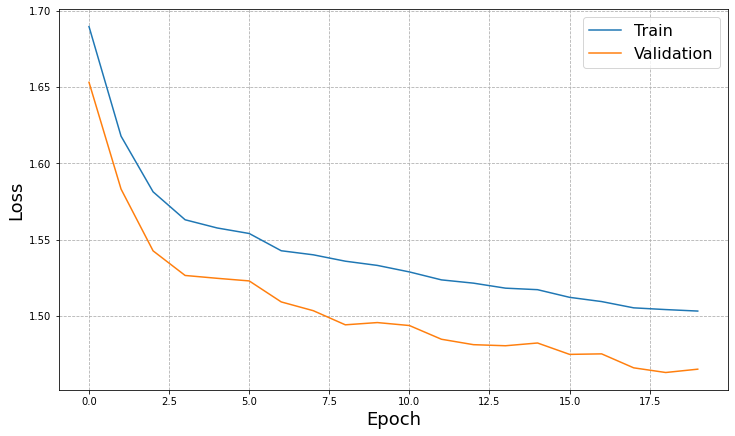

In [53]:
plt.figure(figsize=(12,7))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
#plt.yscale('log')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid(ls='--')
plt.legend(fontsize=16)
plt.savefig('denoise_AE_loss.pdf', bbox_inches='tight')
plt.show()

In [56]:
# Load saved parameters
fine_encoder.load_state_dict(torch.load('finetuned_encoder.pth'))

<All keys matched successfully>

In [57]:
### Test loss
test_outputs, test_labels, test_loss = test_epoch(
    net=fine_encoder,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)
# Print Test loss
print(f"\n\nTEST LOSS : {test_loss}")

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 40/40 [00:00<00:00, 65.94it/s]



TEST LOSS : 1.465110421180725


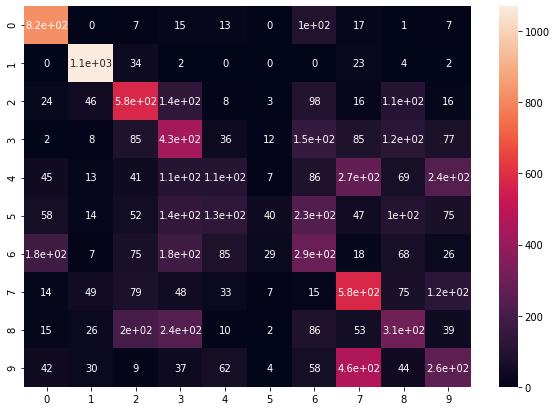

In [63]:
### Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Predicted labels
y_true = test_labels.cpu().data.numpy()
y_pred = test_outputs.cpu().argmax(dim=1).numpy()
# Evaluate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Show the confusion matrix
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True)

## Variational Autoencoder

In [68]:
class VAE(nn.Module):
    
    def __init__(self, x, h1, h2, z):
        super(VAE, self).__init__()
        
        # Encoder part
        self.fc1 = nn.Linear(x, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc31 = nn.Linear(h2, z)
        self.fc32 = nn.Linear(h2, z)
        # Decoder part
        self.fc4 = nn.Linear(z, h2)
        self.fc5 = nn.Linear(h2, h1)
        self.fc6 = nn.Linear(h1, x)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [69]:
vae = VAE(x=784, h1=512, h2=256, z=2)

In [70]:
vae.to(device)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [95]:
optimizer = torch.optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [102]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data[0].cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))

def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_dataloader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, 51):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 162.129013
Train Epoch: 1 [100/60000 (43%)]	Loss: 63.574631
Train Epoch: 1 [200/60000 (85%)]	Loss: 215.456757
====> Epoch: 1 Average loss: 0.6561
====> Test set loss: 168.1266
Train Epoch: 2 [0/60000 (0%)]	Loss: 264.235474
Train Epoch: 2 [100/60000 (43%)]	Loss: 206.239243
Train Epoch: 2 [200/60000 (85%)]	Loss: 112.969482
====> Epoch: 2 Average loss: 0.6417
====> Test set loss: 171.9739
Train Epoch: 3 [0/60000 (0%)]	Loss: 235.430939
Train Epoch: 3 [100/60000 (43%)]	Loss: 48.919018
Train Epoch: 3 [200/60000 (85%)]	Loss: 200.893906
====> Epoch: 3 Average loss: 0.6744
====> Test set loss: 166.2130
Train Epoch: 4 [0/60000 (0%)]	Loss: 120.028687
Train Epoch: 4 [100/60000 (43%)]	Loss: 256.515869
Train Epoch: 4 [200/60000 (85%)]	Loss: 118.123505
====> Epoch: 4 Average loss: 0.6602
====> Test set loss: 167.8008
Train Epoch: 5 [0/60000 (0%)]	Loss: 123.046814
Train Epoch: 5 [100/60000 (43%)]	Loss: 190.078873
Train Epoch: 5 [200/60000 (85%)]	Loss: 193.384201
===

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


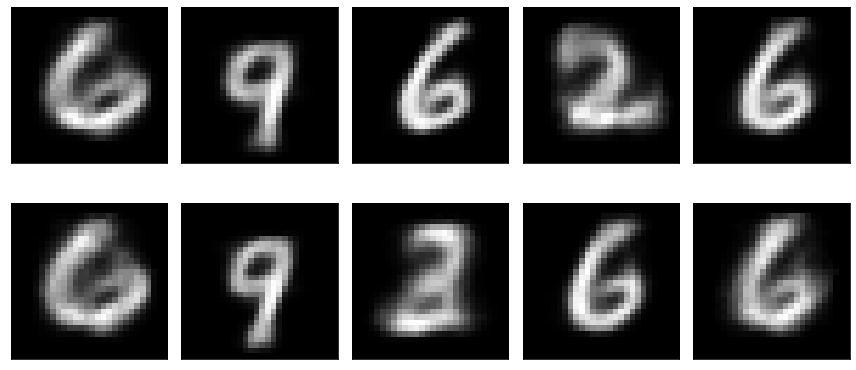

In [103]:
fig, axs = plt.subplots(2, 5, figsize=(12,6))
for ax in axs.flatten():
    with torch.no_grad():
        z = torch.randn(1, 2).to(device)
        sample = vae.decoder(z).to(device)
    sample=sample.view(1, 1, 28, 28)[0].cpu().squeeze().numpy()
    ax.imshow(sample, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('vae_generation.pdf', bbox_inches='tight')
plt.tight_layout()